# Residual Neural Networks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import pickle
from src.utils import *
from src.data import DataGenerator
from src.resnet import *
from collections import OrderedDict

In [4]:
# Load Data
us_temp_data = xr.open_mfdataset('../data/us_temperature.nc').t2m
us_rain_data = xr.open_mfdataset('../data/us_precipitation.nc').tp

us_temp_data = us_temp_data[7:]
assert np.all(us_rain_data.time == us_temp_data.time)
ds = xr.merge([us_temp_data, us_rain_data])

# Split into train and test data
ds_train = normalize(ds.sel(time=slice('2016')))
ds_test_forecast = normalize(ds.sel(time=slice('11/01/2018', '12/31/2018')))
ds_test = normalize(ds.sel(time=slice('2017', '2018')))
valid = normalize(ds.sel(time=slice('2017', '2018')))

_, nlat, nlon = ds_train.t2m.shape

In [5]:
ds_train

<xarray.Dataset>
Dimensions:  (lon: 13, lat: 7, time: 333113)
Coordinates:
  * lon      (lon) float64 230.6 236.2 241.9 247.5 ... 281.2 286.9 292.5 298.1
  * lat      (lat) float64 19.69 25.31 30.94 36.56 42.19 47.81 53.44
  * time     (time) datetime64[ns] 1979-01-01T07:00:00 ... 2016-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(333113, 7, 13), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(333113, 7, 13), meta=np.ndarray>

In [6]:
# then we need a dictionary for all the variables and levels we want to extract from the dataset
dic = OrderedDict({'t2m': None, 'tp': None})

bs=32
lead_time=30*24

In [7]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('2015')), dic, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2016')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test_forecast = DataGenerator(ds_test_forecast, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)
dg_test = DataGenerator(ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM


In [8]:
filters = [128]*50
filters.append(2)
kernels = [7]
kernels.extend([3]*50)
bn_position = 'post'
use_bias = True
dropout = 0.1
l2 = 0
skip = True

model = build_resnet(
    filters, kernels, input_shape=(nlat, nlon, 2),
    bn_position=bn_position, use_bias=use_bias, l2=l2, skip=skip,
    dropout=dropout
)


model.compile(keras.optimizers.Adam(0.5e-4), 'mse')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 13, 2)]   0           []                               
                                                                                                  
 periodic_conv2d (PeriodicConv2  (None, 7, 13, 128)  12672       ['input_1[0][0]']                
 D)                                                                                               
                                                                                                  
 activation (Activation)        (None, 7, 13, 128)   0           ['periodic_conv2d[0][0]']        
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 13, 128)  512         ['activation[0][0]']         

                                                                                                  
 periodic_conv2d_7 (PeriodicCon  (None, 7, 13, 128)  147584      ['add_2[0][0]']                  
 v2D)                                                                                             
                                                                                                  
 activation_7 (Activation)      (None, 7, 13, 128)   0           ['periodic_conv2d_7[0][0]']      
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 7, 13, 128)  512         ['activation_7[0][0]']           
 rmalization)                                                                                     
                                                                                                  
 dropout_7 (Dropout)            (None, 7, 13, 128)   0           ['batch_normalization_7[0][0]']  
          

 activation_14 (Activation)     (None, 7, 13, 128)   0           ['periodic_conv2d_14[0][0]']     
                                                                                                  
 batch_normalization_14 (BatchN  (None, 7, 13, 128)  512         ['activation_14[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 dropout_14 (Dropout)           (None, 7, 13, 128)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 add_6 (Add)                    (None, 7, 13, 128)   0           ['add_5[0][0]',                  
                                                                  'dropout_14[0][0]']             
                                                                                                  
 periodic_

                                                                                                  
 batch_normalization_21 (BatchN  (None, 7, 13, 128)  512         ['activation_21[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 dropout_21 (Dropout)           (None, 7, 13, 128)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 periodic_conv2d_22 (PeriodicCo  (None, 7, 13, 128)  147584      ['dropout_21[0][0]']             
 nv2D)                                                                                            
                                                                                                  
 activation_22 (Activation)     (None, 7, 13, 128)   0           ['periodic_conv2d_22[0][0]']     
          

 dropout_28 (Dropout)           (None, 7, 13, 128)   0           ['batch_normalization_28[0][0]'] 
                                                                                                  
 add_13 (Add)                   (None, 7, 13, 128)   0           ['add_12[0][0]',                 
                                                                  'dropout_28[0][0]']             
                                                                                                  
 periodic_conv2d_29 (PeriodicCo  (None, 7, 13, 128)  147584      ['add_13[0][0]']                 
 nv2D)                                                                                            
                                                                                                  
 activation_29 (Activation)     (None, 7, 13, 128)   0           ['periodic_conv2d_29[0][0]']     
                                                                                                  
 batch_nor

                                                                                                  
 periodic_conv2d_36 (PeriodicCo  (None, 7, 13, 128)  147584      ['dropout_35[0][0]']             
 nv2D)                                                                                            
                                                                                                  
 activation_36 (Activation)     (None, 7, 13, 128)   0           ['periodic_conv2d_36[0][0]']     
                                                                                                  
 batch_normalization_36 (BatchN  (None, 7, 13, 128)  512         ['activation_36[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 dropout_36 (Dropout)           (None, 7, 13, 128)   0           ['batch_normalization_36[0][0]'] 
          

 periodic_conv2d_43 (PeriodicCo  (None, 7, 13, 128)  147584      ['add_20[0][0]']                 
 nv2D)                                                                                            
                                                                                                  
 activation_43 (Activation)     (None, 7, 13, 128)   0           ['periodic_conv2d_43[0][0]']     
                                                                                                  
 batch_normalization_43 (BatchN  (None, 7, 13, 128)  512         ['activation_43[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 dropout_43 (Dropout)           (None, 7, 13, 128)   0           ['batch_normalization_43[0][0]'] 
                                                                                                  
 periodic_

                                                                                                  
 batch_normalization_50 (BatchN  (None, 7, 13, 128)  512         ['activation_50[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 dropout_50 (Dropout)           (None, 7, 13, 128)   0           ['batch_normalization_50[0][0]'] 
                                                                                                  
 add_24 (Add)                   (None, 7, 13, 128)   0           ['add_23[0][0]',                 
                                                                  'dropout_50[0][0]']             
                                                                                                  
 periodic_conv2d_51 (PeriodicCo  (None, 7, 13, 128)  147584      ['add_24[0][0]']                 
 nv2D)    

 batch_normalization_57 (BatchN  (None, 7, 13, 128)  512         ['activation_57[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 dropout_57 (Dropout)           (None, 7, 13, 128)   0           ['batch_normalization_57[0][0]'] 
                                                                                                  
 periodic_conv2d_58 (PeriodicCo  (None, 7, 13, 128)  147584      ['dropout_57[0][0]']             
 nv2D)                                                                                            
                                                                                                  
 activation_58 (Activation)     (None, 7, 13, 128)   0           ['periodic_conv2d_58[0][0]']     
                                                                                                  
 batch_nor

                                                                                                  
 add_31 (Add)                   (None, 7, 13, 128)   0           ['add_30[0][0]',                 
                                                                  'dropout_64[0][0]']             
                                                                                                  
 periodic_conv2d_65 (PeriodicCo  (None, 7, 13, 128)  147584      ['add_31[0][0]']                 
 nv2D)                                                                                            
                                                                                                  
 activation_65 (Activation)     (None, 7, 13, 128)   0           ['periodic_conv2d_65[0][0]']     
                                                                                                  
 batch_normalization_65 (BatchN  (None, 7, 13, 128)  512         ['activation_65[0][0]']          
 ormalizat

 periodic_conv2d_72 (PeriodicCo  (None, 7, 13, 128)  147584      ['dropout_71[0][0]']             
 nv2D)                                                                                            
                                                                                                  
 activation_72 (Activation)     (None, 7, 13, 128)   0           ['periodic_conv2d_72[0][0]']     
                                                                                                  
 batch_normalization_72 (BatchN  (None, 7, 13, 128)  512         ['activation_72[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 dropout_72 (Dropout)           (None, 7, 13, 128)   0           ['batch_normalization_72[0][0]'] 
                                                                                                  
 add_35 (A

 nv2D)                                                                                            
                                                                                                  
 activation_79 (Activation)     (None, 7, 13, 128)   0           ['periodic_conv2d_79[0][0]']     
                                                                                                  
 batch_normalization_79 (BatchN  (None, 7, 13, 128)  512         ['activation_79[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 dropout_79 (Dropout)           (None, 7, 13, 128)   0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 periodic_conv2d_80 (PeriodicCo  (None, 7, 13, 128)  147584      ['dropout_79[0][0]']             
 nv2D)    

 batch_normalization_86 (BatchN  (None, 7, 13, 128)  512         ['activation_86[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 dropout_86 (Dropout)           (None, 7, 13, 128)   0           ['batch_normalization_86[0][0]'] 
                                                                                                  
 add_42 (Add)                   (None, 7, 13, 128)   0           ['add_41[0][0]',                 
                                                                  'dropout_86[0][0]']             
                                                                                                  
 periodic_conv2d_87 (PeriodicCo  (None, 7, 13, 128)  147584      ['add_42[0][0]']                 
 nv2D)                                                                                            
          

 ormalization)                                                                                    
                                                                                                  
 dropout_93 (Dropout)           (None, 7, 13, 128)   0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 periodic_conv2d_94 (PeriodicCo  (None, 7, 13, 128)  147584      ['dropout_93[0][0]']             
 nv2D)                                                                                            
                                                                                                  
 activation_94 (Activation)     (None, 7, 13, 128)   0           ['periodic_conv2d_94[0][0]']     
                                                                                                  
 batch_normalization_94 (BatchN  (None, 7, 13, 128)  512         ['activation_94[0][0]']          
 ormalizat

In [9]:
model.fit(dg_train, epochs=100, validation_data=dg_valid, 
          callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0,
                        patience=2,
                        verbose=1, 
                        mode='auto'
                    )]
         )

Epoch 1/100
10113/10113 [==============================] - 566s 54ms/step - loss: 3.2691 - val_loss: 0.8679
Epoch 2/100
10113/10113 [==============================] - 545s 54ms/step - loss: 0.8829 - val_loss: 0.8422
Epoch 3/100
10113/10113 [==============================] - 543s 54ms/step - loss: 0.7682 - val_loss: 0.8394
Epoch 4/100
10113/10113 [==============================] - 544s 54ms/step - loss: 0.7352 - val_loss: 0.8297
Epoch 5/100
10113/10113 [==============================] - 543s 54ms/step - loss: 0.7194 - val_loss: 0.8126
Epoch 6/100
10113/10113 [==============================] - 542s 54ms/step - loss: 0.7066 - val_loss: 0.8225
Epoch 7/100
10113/10113 [==============================] - 544s 54ms/step - loss: 0.6928 - val_loss: 0.8184
Epoch 7: early stopping


In [16]:
compute_weighted_rmse(create_predictions(model, dg_test), valid).compute()

525/525 [==============================] - 9s 17ms/step


<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 0.5355
    tp       float64 0.6255

In [17]:
fc = create_predictions(model, dg_test_forecast)

24/24 [==============================] - 0s 17ms/step


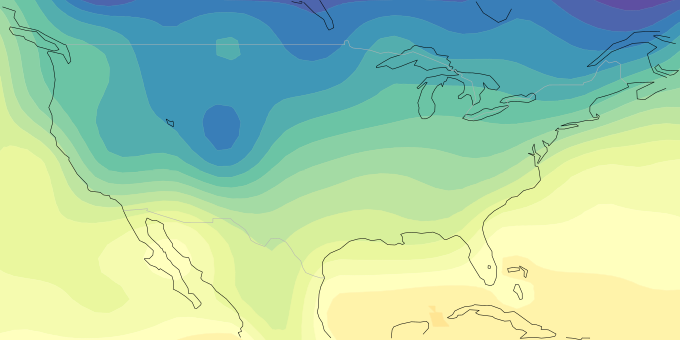

In [18]:
plot_temp(normalize(fc.t2m[0]))

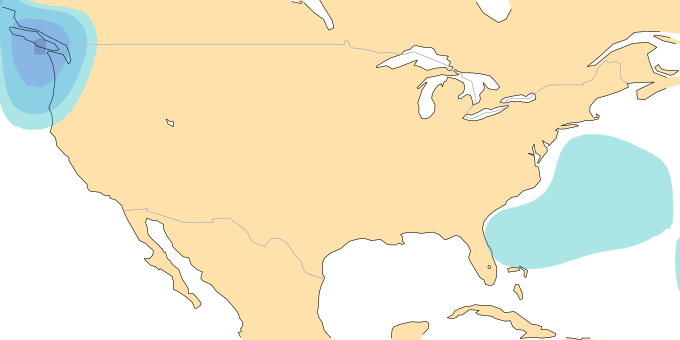

In [19]:
plot_rain(normalize(fc.tp[0]))

In [20]:
model.save_weights('../models/resnet.h5')
# model.load_weights('../models/resnet.h5')

In [21]:
fc.t2m[-720:].to_netcdf('../data/us_temperature_resnet_forecast.nc')
fc.tp[-720:].to_netcdf('../data/us_precipitation_resnet_forecast.nc')